In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Visualisations

In [30]:
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
plotly.offline.init_notebook_mode(connected=True)

# Distribution of Tweets over States in Australia

* The pie chart below shows how many tweets our system has harvested across different Australian states.

* Overall, about two thirds of all tweets comes from **New South Wales and Victoria**, while other 5 states yielded the rest tweets.

* Also, the total number of collected tweets is over 1.8 million tweets.

In [31]:
plot_df = data_df.groupby(level='state').sum().sort_values('tweets_count', ascending=False)

In [32]:
labels = plot_df.index.values.tolist()
values = plot_df.values.ravel().tolist()
trace = go.Pie(labels=labels, values=values, 
               hoverinfo='label+percent', sort=True, showlegend=False,
               textinfo='value+label', textposition='outside')
layout = go.Layout(title='Number of Collected Tweets by States')
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig, filename='basic_pie_chart')

In [33]:
plot_df = topic_data_df.groupby(level='state').sum().sort_values('tweets_count', ascending=False)

* The pie-chart below illustrates the distribution of topic related tweets. In our case, that is the tweets related to **cryptocurrencies and blockchain technology**.

* Intrestingly, the proportion of topic related tweets **in Queensland** is higher in comparison to all tweets chart.

In [34]:
labels = plot_df.index.values.tolist()
values = plot_df.values.ravel().tolist()
trace = go.Pie(labels=labels, values=values, 
               hoverinfo='label+percent', sort=True, showlegend=False,
               textinfo='value+label', textposition='outside')
layout = go.Layout(title='Number of Collected Topic Tweets by States')
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig, filename='basic_pie_chart')

In [35]:
def plot_area_chart(plot_df, graph_title):
    button_masks = []
    data = []
    territories = plot_df.columns.get_level_values(0).unique()
    for idx, territory in enumerate(territories):
        mask = np.zeros(territories.shape[0]*(len(sentiment_columns)+1))
        territory_df = plot_df[territory][sentiment_columns]


        cols = []
        for jdx, col in enumerate(territory_df.columns):
            cols.append(col)
            trace = go.Scatter(
                x=territory_df.index.values,
                y=territory_df[cols].sum(axis=1).values.ravel(),
                text=territory_df[col],
                hoverinfo='x+text',
                fill='tonexty',
                visible=(idx==0),
                fillcolor=sentiment_colors[col],
                line = dict(color = sentiment_colors[col]),
                name=col,
            )
            data.append(trace)
            mask[idx*(len(sentiment_columns)+1) + jdx] = 1
        dummy_trace = go.Scatter(x=[None], y=[None], name='<b>Tweet Sentiment</b>', visible=(idx==0),
                                line={'color': 'rgba(0, 0, 0, 0)'})
        data.append(dummy_trace)
        mask[idx*(len(sentiment_columns)+1) + len(sentiment_columns)] = 1

        button_masks.append(list(mask==1))

    buttons = []
    for idx, mask in enumerate(button_masks):
        button = dict(
            label = territories[idx],
            method = 'update',
            args = [{'visible': mask},
                    {'title': '{} in {}'.format(graph_title, territories[idx])}],
        )
        buttons.append(button)
    updatemenus = list([dict(showactive = False,
                             buttons=buttons,

                             x = 0.01, xanchor = 'left',
                             y = 1.0,
                             yanchor = 'top',)])

    layout = go.Layout(title=graph_title,
                       xaxis=dict(title='Tweet Creation Date'),
                       yaxis=dict(title='Number of Collected Tweets'),
                       updatemenus=updatemenus,
                      )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig,filename='basic-area')

# Tweets by Sentiment, GCCSA Area and Time

## Distribution of Tweets by GCCSA Areas and Sentiment of Tweets

**GCCSA** - Greater Capital City Statistical Areas

* This chart issultrates how many tweets were harvested by the system and reveals people's opinions/sentiment across different regions in Australia over the time.<br>
* The data is represented from April 1st 2018 to the current date.<br> _From April 27 the number of tweets increased after we started to stream all Australian tweets (Before that date all the tweets were collected over the Search API)_

In [36]:
sentiment_columns = ['Positive', 'Neutral', 'Negative']
sentiment_colors = {'Positive': 'rgb(120,220,120)', 'Negative':'rgb(245,99,99)', 'Neutral': 'rgb(250,250,150)'}

In [37]:
def add_missed_columns(df):
    l0_values, l1_values  = df.columns.levels
    mask = np.ones((l0_values.shape[0], l1_values.shape[0]), dtype=int)
    mask[df.columns.labels] = 0
    l0,l1 = mask.nonzero()
    for i, j in zip(l0, l1):
        df[l0_values[i],l1_values[j]] = 0
    return df.sort_index(axis=1, level=0)

In [38]:
def transform_df(df):
    group_columns = ['date', 'gccsa_area', 'sentiment']
    plot_df = df.groupby(level=group_columns).sum().unstack(level=['gccsa_area','sentiment'], fill_value=0)
    plot_df = plot_df.loc['2018-04-01':]
    plot_df.columns = plot_df.columns.droplevel(0)
    plot_df = add_missed_columns(plot_df)
    plot_df.sort_index(level=0, axis=1, inplace=True)

    temp_df = plot_df.groupby(axis=1, level='sentiment').sum()
    for col in sentiment_columns:
        plot_df.insert(0, ('All Austalia', col), temp_df[col])
    return plot_df

In [39]:
plot_area_chart(transform_df(data_df), graph_title = 'Number of Tweets by Creation Date')

## Distribution of Topic-Related Tweets by GCCSA Areas and Sentiment of Tweets

This graph is the same like the previous one, but it show data about the tweets related to the selected topic.

In [40]:
plot_area_chart(transform_df(topic_data_df), graph_title = 'Number of Blockchain-Related Tweets by Creation Date')

# Scattered Map Plot of AURIN and Twitter Data

The map below illustrates AURIN data and tweets sentiment count for each Statistical Area-4 level scattered on the map. The color of the markers represent the income level.

In [41]:
mapbox_access_token = 'pk.eyJ1Ijoidml0YWx5LXlha3V0ZW5rbyIsImEiOiJjamd3ZGJpMTQwcDA2MzNsNjg2dTJzeG1zIn0.shxkPXdNpbwF1UI2Gm24fg'

In [42]:
sa4_points_df = pd.read_json('notebooks/sa4_center.json')
sa4_points_df.set_index('SA4_name', inplace=True)
sa4_points_df['lat'] = sa4_points_df.Centre.apply(lambda x: x[0][1])
sa4_points_df['lng'] = sa4_points_df.Centre.apply(lambda x: x[0][0])
del sa4_points_df['Centre']

In [43]:
sa4_df = sa4_df.join(sa4_points_df)

In [44]:
sa4_df['Unemployment Rate'] = sa4_df['Unemployment Rate'].apply(lambda x: '{:.1f}%'.format(x))

In [45]:
columns = sentiment_columns + ['Median total personal income weekly', 
                               'Median total family income weekly', 'Unemployment Rate']
def format_title(vector):
    lines = []
    for key, value in vector.iteritems():
        lines.append('{}: {}'.format(key, value))
    return '<br>' + '</br>'.join(lines)
    #return lines
sa4_df['text'] = sa4_df[columns].astype(str).apply(format_title, axis=1)

In [46]:
scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [ dict(
    type = 'scattermapbox',
    lat=sa4_df.lat,
    lon=sa4_df.lng,
    text=list(sa4_df.index.values.ravel()),
    mode = 'markers+text',
    hoverinfo='text',
    hovertext=sa4_df.text,
    marker=go.Marker(
            #symbol='square-15.svg',
            size = 12,
            opacity = 0.6,
            autocolorscale = False,
            #colorscale = 'Viridis',
        colorscale = 'Electric',
        reversescale=True,
            cmin = 0,
            color = sa4_df['Median total personal income weekly'],
            cmax = sa4_df['Median total personal income weekly'].max(),
            colorbar=dict( title="Median Personal<br>Weekly Income")
            )
        )]

layout = dict(
    title = 'Scatter Map Plot of AURIN and Twitter Data',
    colorbar = True,
    width=1000,
    height=850,
    margin=go.Margin(l=10, r=10, b=10, t=35, pad=4),
        mapbox=dict(
                    accesstoken=mapbox_access_token,
                    bearing=0,
                    center=dict(
                        lat=-28,
                        lon=134
                    ),
        pitch=0,
        zoom=3.8
    ),
    )

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False, filename='' )

# Scenario Based Regression Analysis

**Description:**

**Introduction:**
We obtained only a small sample of tweets strictly related to CryptoCurrencies from the 1.23 Million that we harvested, so using concepts of Statistical Inference we built a least square regression model to estimate the correlation between the Sentiment and the income/unemployment rate for the whole population of Australia.


## Negative Sentiment vs Median Family Income for Urban Areas in Australia

**Y-Axis:**
The chance( in %) of a tweet about Crypto being Negative.


**X-Axis:**
The corresponding median family income that the each point (Urban area) has, which is obtained from AURIN.


Every point on the Linear Regression Graph represents the proportion of the particular sentiment to the total tweets about Cryptocurrencies and its corresponding median family income for each urban area.

In [47]:
sentiment_data = topic_gccsa_df[sentiment_columns]
counts = sentiment_data.sum(axis=1)
sentiment_data = sentiment_data[counts > 15]
counts = counts[counts > 15]
for idx, count in counts.iteritems():
    sentiment_data.loc[idx] = sentiment_data.loc[idx]/count
sentiment_data = sentiment_data.join(gccsa_labour_force_df['Unemployment Rate'])\
                                .join(gccsa_median_income_df['Median total personal income weekly'])

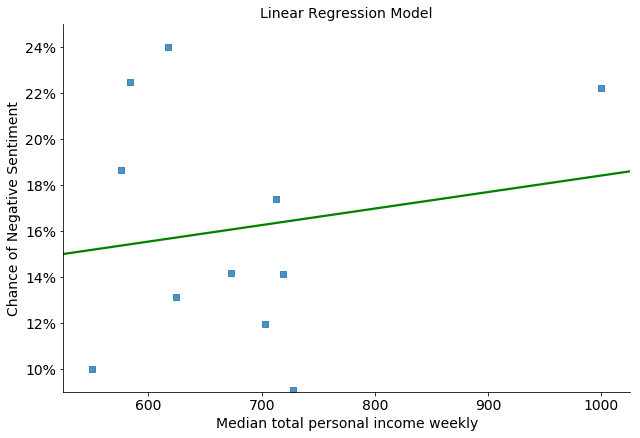

In [48]:
#sns.regplot(sentiment_data['Median total family income weekly'], sentiment_data['Negative'])
sns.lmplot('Median total personal income weekly', 'Negative', sentiment_data, size=6,
            aspect=1.5, markers='s', ci=0, line_kws={'color':'green'}, order=1)
ax = plt.gca()
plt.title('Linear Regression Model')
ax.set_ylabel('Chance of Negative Sentiment')
ax.set_ylim((0.09, 0.25))
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
plt.show()

•	Every circle in the below QQPlot(Quantile Quantile) represents the relation between the sample residual quantiles and Normal Quantiles. If all circles are close, or lie on the line then our assumption that data is Normally Distributed is accurate, which will validate the graph above.

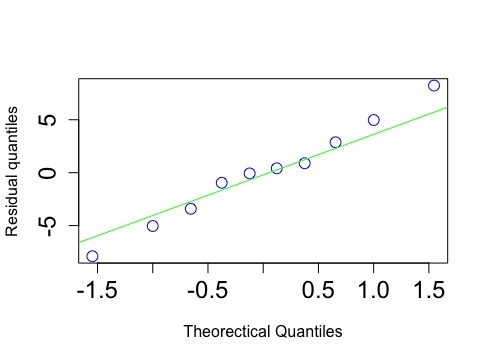

In [49]:
from IPython.display import Image
Image("notebooks/qq-neg-income.jpeg", width=700)

## Positive Sentiment vs Unemployment Rate for Urban Areas in Australia

**Y-Axis:**
The chance( in %) of a tweet about Cryptocurrencies being Positive.


**X-Axis:**
The corresponding unemployment rate that the each point (Urban area) has, which is obtained from AURIN.

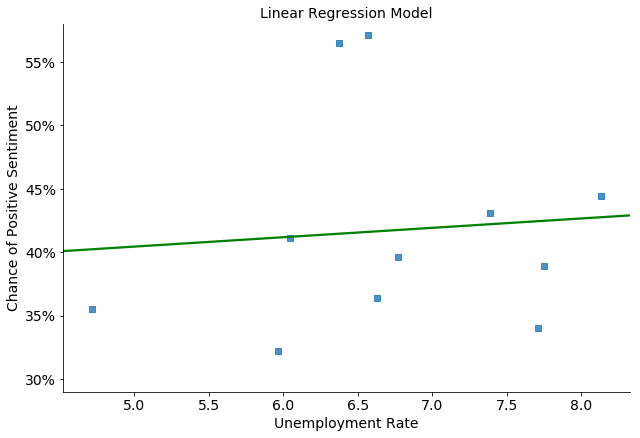

In [50]:
#sns.regplot(sentiment_data['Median total family income weekly'], sentiment_data['Negative'])
sns.lmplot('Unemployment Rate', 'Positive', sentiment_data, size=6,
            aspect=1.5, markers='s', ci=0, line_kws={'color':'green'}, order=1)
ax = plt.gca()
plt.title('Linear Regression Model')
ax.set_ylabel('Chance of Positive Sentiment')
ax.set_ylim((0.29, 0.58))
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
plt.show()

•	Every circle in the below QQPlot(Quantile Quantile) represents the relation between the sample residual quantiles and Normal Quantiles. If all circles are close, or lie on the line then our assumption that data is Normally Distributed is accurate, which will validate the graph above.

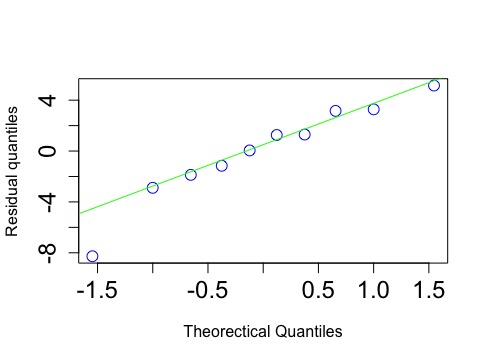

In [51]:
from IPython.display import Image
Image("notebooks/pos-qq.jpeg", width=700)
